# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras import to_categorical

In [4]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [5]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [6]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
df.columns

Index(['emotion', 'pixels'], dtype='object')

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [8]:
## parsing data here
images, labels = parse_data(df)

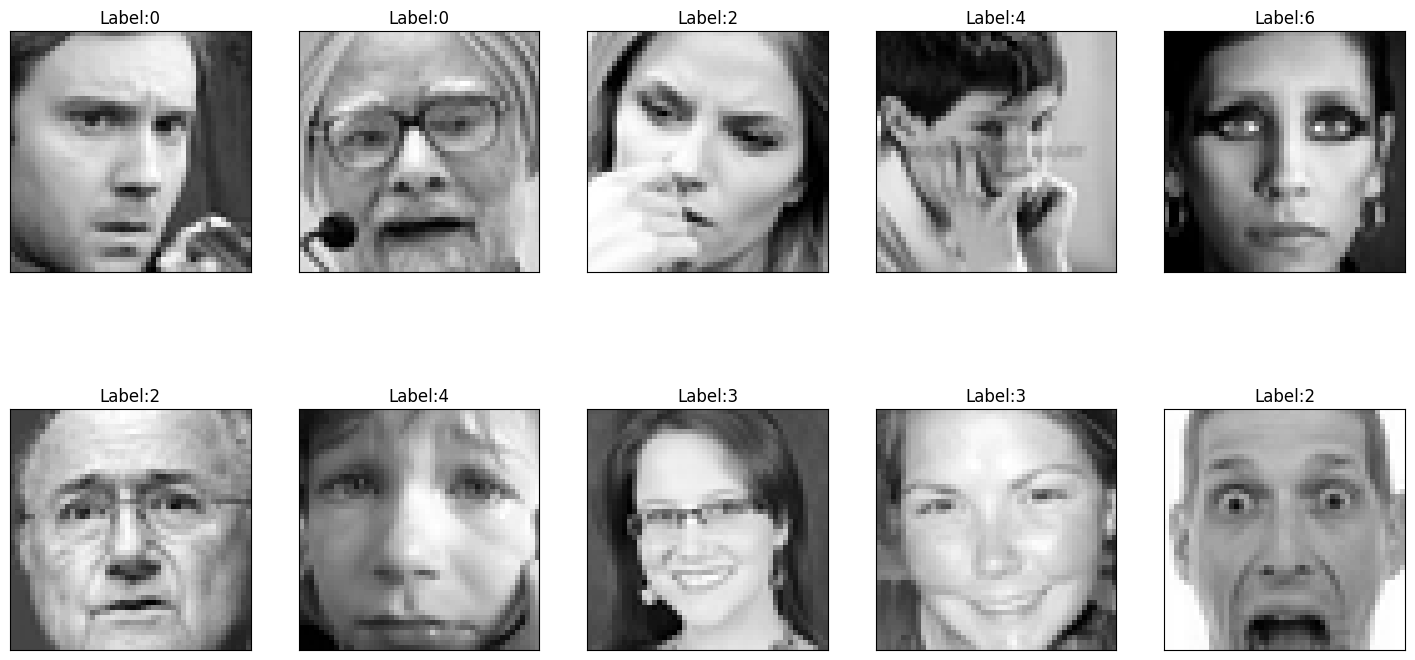

In [9]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [10]:
## apply PCA here
images_reshaped = np.array(df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32')).tolist())
y=df['emotion']

n_samples, n_features = images_reshaped.shape

images_reshaped = (images_reshaped - images_reshaped.mean(axis=0)) / images_reshaped.std(axis=0)

pca=PCA(n_components=2)
pca.fit(images_reshaped)
images_pca = pca.transform(images_reshaped)
print(images_pca.shape)

(35887, 2)


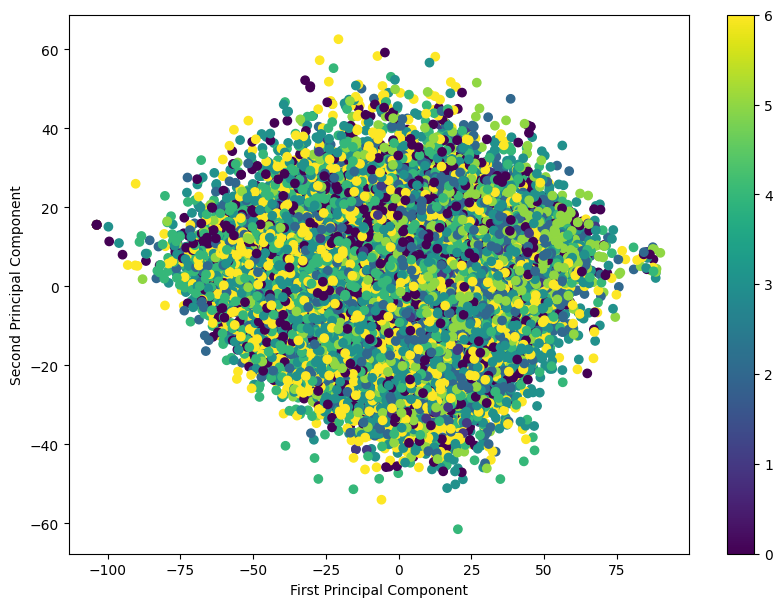

In [11]:
# Plot the transformed data
plt.figure(figsize=(10, 7))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

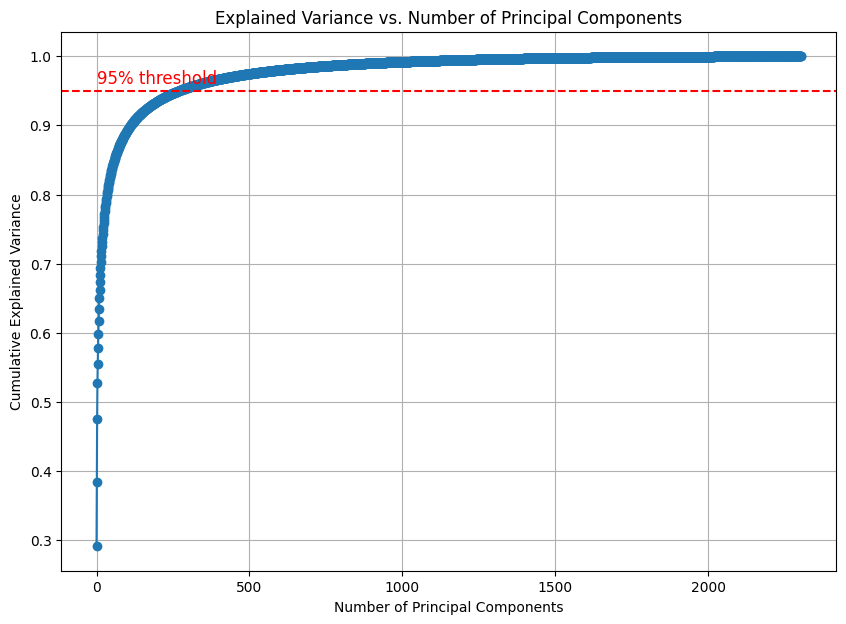

Optimal number of principal components to explain 95% of variance: 270


In [12]:
# Assume X is your data
pca = PCA().fit(images_reshaped)

# Calculate cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 7))
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.text(0.5, 0.96, '95% threshold', color='red', fontsize=12)
plt.grid(True)
plt.show()

# Determine the optimal number of components
optimal_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print("Optimal number of principal components to explain 95% of variance:", optimal_components)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(images_reshaped)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Print the shapes of the resulting splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (21531, 2304) (21531,)
Validation set shape: (7178, 2304) (7178,)
Test set shape: (7178, 2304) (7178,)


In [14]:
# Train and evaluate Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Logistic Regression Training Accuracy:", lr.score(X_train, y_train))
print("Logistic Regression Validation Accuracy:", lr.score(X_val, y_val))
print("Logistic Regression Test Accuracy:", lr.score(X_test, y_test))

C:\Users\phuon\PycharmProjects\miniprojectML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Training Accuracy: 0.548186335980679
Logistic Regression Validation Accuracy: 0.3211200891613263
Logistic Regression Test Accuracy: 0.32502089718584565


In [15]:
# Train and evaluate Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Random Forest Training Accuracy:", rf.score(X_train, y_train))
print("Random Forest Validation Accuracy:", rf.score(X_val, y_val))
print("Random Forest Test Accuracy:", rf.score(X_test, y_test))

Random Forest Training Accuracy: 0.9987459941479727
Random Forest Validation Accuracy: 0.4458066313736417
Random Forest Test Accuracy: 0.44413485650599055


In [19]:
# Train and evaluate Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
print("Support Vector Machine Training Accuracy:", svm.score(X_train, y_train))
print("Support Vector Machine Validation Accuracy:", svm.score(X_val, y_val))
print("Support Vector Machine Test Accuracy:", svm.score(X_test, y_test))

Support Vector Machine Training Accuracy: 0.6369420835075008
Support Vector Machine Validation Accuracy: 0.4427417107829479
Support Vector Machine Test Accuracy: 0.4400947339091669


In [17]:
#MLP
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
print("MLP Training Accuracy:", mlp.score(X_train, y_train))
print("MLP Validation Accuracy:", mlp.score(X_val, y_val))
print("MLP Test Accuracy:", mlp.score(X_test, y_test))

MLP Training Accuracy: 0.98913194928243
MLP Validation Accuracy: 0.39203120646419615
MLP Test Accuracy: 0.40066870994706044


In [20]:
pca = PCA(n_components=270)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Prepare data for MLP
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)
y_test_categorical = to_categorical(y_test)

# Train and evaluate Logistic Regression on PCA data
log_reg_pca = LogisticRegression(max_iter=1000)
log_reg_pca.fit(X_train_pca, y_train)
y_pred_log_reg_pca = log_reg_pca.predict(X_val_pca)
print("Logistic Regression (PCA)\n", classification_report(y_val, y_pred_log_reg_pca))

# Train and evaluate Random Forest on PCA data
rf_clf_pca = RandomForestClassifier(n_estimators=100)
rf_clf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_clf_pca.predict(X_val_pca)
print("Random Forest (PCA)\n", classification_report(y_val, y_pred_rf_pca))

# Train and evaluate SVM on PCA data
svm_clf_pca = SVC()
svm_clf_pca.fit(X_train_pca, y_train)
y_pred_svm_pca = svm_clf_pca.predict(X_val_pca)
print("SVM (PCA)\n", classification_report(y_val, y_pred_svm_pca))


# Define and train MLP model on PCA data
mlp_model_pca = Sequential()
mlp_model_pca.add(Dense(512, input_shape=(X_train_pca.shape[1],), activation='relu'))
mlp_model_pca.add(Dropout(0.5))
mlp_model_pca.add(Dense(256, activation='relu'))
mlp_model_pca.add(Dropout(0.5))
mlp_model_pca.add(Dense(len(np.unique(y)), activation='softmax'))

mlp_model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_model_pca.fit(X_train_pca, to_categorical(y_train), epochs=50, batch_size=256, validation_data=(X_val_pca, to_categorical(y_val)))

# Evaluate MLP model on PCA data
y_pred_mlp_pca = np.argmax(mlp_model_pca.predict(X_val_pca), axis=1)
print("MLP (PCA)\n", classification_report(y_val, y_pred_mlp_pca))

Logistic Regression (PCA)
               precision    recall  f1-score   support

           0       0.28      0.16      0.20       991
           1       0.12      0.03      0.05       109
           2       0.27      0.16      0.20      1024
           3       0.44      0.68      0.54      1798
           4       0.29      0.29      0.29      1215
           5       0.48      0.50      0.49       801
           6       0.35      0.33      0.34      1240

    accuracy                           0.38      7178
   macro avg       0.32      0.31      0.30      7178
weighted avg       0.35      0.38      0.35      7178
Random Forest (PCA)
               precision    recall  f1-score   support

           0       0.41      0.14      0.21       991
           1       1.00      0.21      0.35       109
           2       0.46      0.21      0.28      1024
           3       0.35      0.81      0.49      1798
           4       0.32      0.25      0.28      1215
           5       0.82      0.

C:\Users\phuon\PycharmProjects\miniprojectML\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2125 - loss: 2.8657 - val_accuracy: 0.2928 - val_loss: 1.7756
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2838 - loss: 1.7813 - val_accuracy: 0.3332 - val_loss: 1.7215
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3079 - loss: 1.7289 - val_accuracy: 0.3509 - val_loss: 1.6820
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3396 - loss: 1.6799 - val_accuracy: 0.3707 - val_loss: 1.6417
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3489 - loss: 1.6568 - val_accuracy: 0.3819 - val_loss: 1.6123
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3613 - loss: 1.6229 - val_accuracy: 0.3881 - val_loss: 1.5932
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3696 - loss: 1.5934 - val_accuracy: 0.3931 - val_loss: 1.5834
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3797 - loss: 1.5742 - val_accuracy: 0.3959 - val_loss

Among the evaluated models, Random Forest and SVM perform the best, exhibiting higher accuracy and balanced precision and recall across classes. The MLP model also shows promise, while Logistic Regression appears to be the weakest of the four.

The addition of PCA dimensionality reduction seems to enhance the Logistic Regression model’s performance, but it still falls behind the other three. Overall, Random Forest, SVM, and MLP (PCA) demonstrate strong performance, with MLP being the top performer

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)